Note, still in the process of experimenting with parameters

Import packages

In [11]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pds
import datetime as dt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

In [29]:
data = pds.read_pickle('dataset_model2v2_w_label.pkl')

In [30]:
labels = data['label']
labels.reset_index().drop(columns=['index'])
data = data.drop(columns=['label'])
data.head()

,1,2,3,4,5,6,7,8,9,10,11,hr_sin,hr_cos,dir_sin,dir_cos,speed,ttjs,latitude,longitude,journey_number
0,1,0,0,0,0,0,0,0,0,0,0,0.866025,0.5,0.54024,-0.841511,0.0,0.0,0.326317,0.924521,1
1,1,0,0,0,0,0,0,0,0,0,0,0.866025,0.5,0.54024,-0.841511,0.0,0.0,0.326237,0.925287,1
2,1,0,0,0,0,0,0,0,0,0,0,0.866025,0.5,0.54024,-0.841511,0.0,0.0,0.326156,0.925670,1
3,1,0,0,0,0,0,0,0,0,0,0,0.866025,0.5,0.54024,-0.841511,0.0,0.0,0.326076,0.926437,1
4,1,0,0,0,0,0,0,0,0,0,0,0.866025,0.5,0.54024,-0.841511,0.0,0.0,0.326116,0.926437,1


Import data

One hot encode segments, normalize columns and create final dataset

In [17]:
df = data

In [15]:
# Make segments categorical
dataset = pds.get_dummies(df['segment_number'])

# Combine segments, timestamps and time from journey start

# Cyclical timestamps 
dataset['hr_sin'] = np.sin(df.timestamp.dt.hour*(2.*np.pi/24))
dataset['hr_cos'] = np.cos(df.timestamp.dt.hour*(2.*np.pi/24))

# Convert to radians befor trigonometric functions
dataset['dir_sin'] = np.sin(df.direction*(np.pi/180))
dataset['dir_cos'] = np.cos(df.direction*(np.pi/180))

dataset['speed'] = (df['speed']-df['speed'].min())/(df['speed'].max()-df['speed'].min())
# Previousla was 'time_since_journey_start'
dataset['ttjs'] = (df['ttjs']-df['ttjs'].min())/(df['ttjs'].max()-df['ttjs'].min())

dataset['latitude'] = (df['latitude']-df['latitude'].min())/(df['latitude'].max()-df['latitude'].min())
dataset['longitude'] = (df['longitude']-df['longitude'].min())/(df['longitude'].max()-df['longitude'].min())

# Include journey number to select entire journeys
dataset['journey_number'] = df['journey_number']

#skip_first = dataset[dataset[1] == 0].index
#dataset = dataset.loc[skip_first].reset_index().drop(columns=['index'])
#df = df.loc[skip_first].reset_index().drop(columns=['index'])

dataset.head()

KeyError: 'segment_number'

In [ ]:
dataset.to_pickle('dataset_model2v2_w_label.pkl')

Select an arbitrary number of test journeys

In [37]:
dataset = data

In [38]:
# Roughly 20%
num_test_segments = 700 
msk = np.random.randint(1, dataset.journey_number.unique()[-1], num_test_segments)
mask = dataset['journey_number'].isin(msk)

Divide training and test data, 80% training data

In [36]:
labels

0          71.0
1          70.0
2          69.0
3          68.0
4          67.0
5          66.0
6          65.0
7          64.0
8          63.0
9          62.0
10         61.0
11         60.0
12         59.0
13         58.0
14         57.0
15         56.0
16         55.0
17         54.0
18         53.0
19         52.0
20         51.0
21         50.0
22         49.0
23         48.0
24         47.0
25         46.0
26         45.0
27         44.0
28         43.0
29         42.0
           ... 
3311970    29.0
3311971    28.0
3311972    27.0
3311973    26.0
3311974    25.0
3311975    24.0
3311976    23.0
3311977    22.0
3311978    21.0
3311979    20.0
3311980    19.0
3311981    18.0
3311982    17.0
3311983    16.0
3311984    15.0
3311985    14.0
3311986    13.0
3311987    12.0
3311988    11.0
3311989    10.0
3311990     9.0
3311991     8.0
3311992     7.0
3311993     6.0
3311994     5.0
3311995     4.0
3311996     3.0
3311997     2.0
3311998     1.0
3311999     0.0
Name: label, Length: 331

In [39]:
train_input = dataset[~mask]
test_input = dataset[mask]

train_labels = labels[~mask]#df['t'][~mask]
test_labels = labels[mask]#df['t'][mask]

In [40]:
# Journey numbers were needed up until this point
train_data = train_input.drop(columns=['journey_number'])
test_data = test_input.drop(columns=['journey_number'])

Build model

In [57]:
model = keras.Sequential([
	keras.layers.Dense(len(train_data.columns), activation=tf.nn.sigmoid, input_shape=(train_data.shape[1],)),
    keras.layers.Dense(len(train_data.columns), activation=tf.nn.relu),
    keras.layers.Dense(len(train_data.columns), activation=tf.nn.relu),
    keras.layers.Dense(3),
	keras.layers.Dense(1)
	])

#optimizer = tf.train.RMSPropOptimizer(0.001)
optimizer = keras.optimizers.Adadelta()
model.compile(loss='mae', optimizer = optimizer, metrics=['mae'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 19)                380       
_________________________________________________________________
dense_5 (Dense)              (None, 19)                380       
_________________________________________________________________
dense_6 (Dense)              (None, 19)                380       
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 60        
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 4         
Total params: 1,204
Trainable params: 1,204
Non-trainable params: 0
_________________________________________________________________
None


Fit model, 10% of the training data is used as validation set

In [58]:
EPOCHS=10
# Initial_epoch can be set to resume training after preciously run epochs
model.fit(train_data.values, train_labels.values, epochs = EPOCHS, validation_split=0.1, initial_epoch=0)

Train on 2462930 samples, validate on 273659 samples
Epoch 1/10
2462930/2462930 [==============================] - 76s 31us/step - loss: 12.8298 - mean_absolute_error: 12.8298 - val_loss: 11.9973 - val_mean_absolute_error: 11.9973
Epoch 2/10
2462930/2462930 [==============================] - 75s 31us/step - loss: 11.7711 - mean_absolute_error: 11.7711 - val_loss: 11.7732 - val_mean_absolute_error: 11.7732
Epoch 3/10
2462930/2462930 [==============================] - 76s 31us/step - loss: 11.5832 - mean_absolute_error: 11.5832 - val_loss: 11.7900 - val_mean_absolute_error: 11.7900
Epoch 4/10
2462930/2462930 [==============================] - 75s 30us/step - loss: 11.4741 - mean_absolute_error: 11.4741 - val_loss: 11.7215 - val_mean_absolute_error: 11.7215
Epoch 5/10
2462930/2462930 [==============================] - 74s 30us/step - loss: 11.3967 - mean_absolute_error: 11.3967 - val_loss: 11.5231 - val_mean_absolute_error: 11.5231
Epoch 6/10
2462930/2462930 [=============================

Save model to disk

In [ ]:
# serialize model to YAML
model_yaml = model.to_yaml()
with open("model2v2.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)

# Serialize weights to HDF5
model.save_weights("model2v2.h5")

Load model example

In [ ]:
# Load YAML and create model
yaml_file = open('model2v2.yaml', 'r')
loaded_model_yaml = yaml_file.read()
yaml_file.close()
model = keras.models.model_from_yaml(loaded_model_yaml)

# Load weights into new model
model.load_weights("model2v2.h5")

In [ ]:
#optimizer = tf.train.RMSPropOptimizer(0.001)
optimizer = keras.optimizers.Adadelta()
model.compile(loss='mae', optimizer = optimizer, metrics=['mae'])
print(model.summary())

## Evaluate model on all segments 

Evaluate model

In [45]:
model.evaluate(test_data.values, test_labels.values)

575411/575411 [==============================] - 5s 9us/step


[11.684324792974733, 11.684324792974733]

An arbitrary number from `msk` is chosen, i.e. a journey, to a comparison with original data.

In [46]:
selected_journey = np.random.choice(msk)
to_test = test_input[test_input['journey_number'] == selected_journey]
model_to_predict = to_test.drop(columns=['journey_number'])
predictions = model.predict(model_to_predict.values, batch_size=1, verbose=1)

959/959 [==============================] - 0s 208us/step


In [47]:
journey_ = test_input.index[test_input['journey_number'] == selected_journey]
j_labels_ = test_labels.loc[journey_]
j_labels = j_labels_.reset_index().drop(columns=['index'])

Green line is the predicted time, red is the actual time. Note that the predicted time is the time it takes to drive an entire segment.


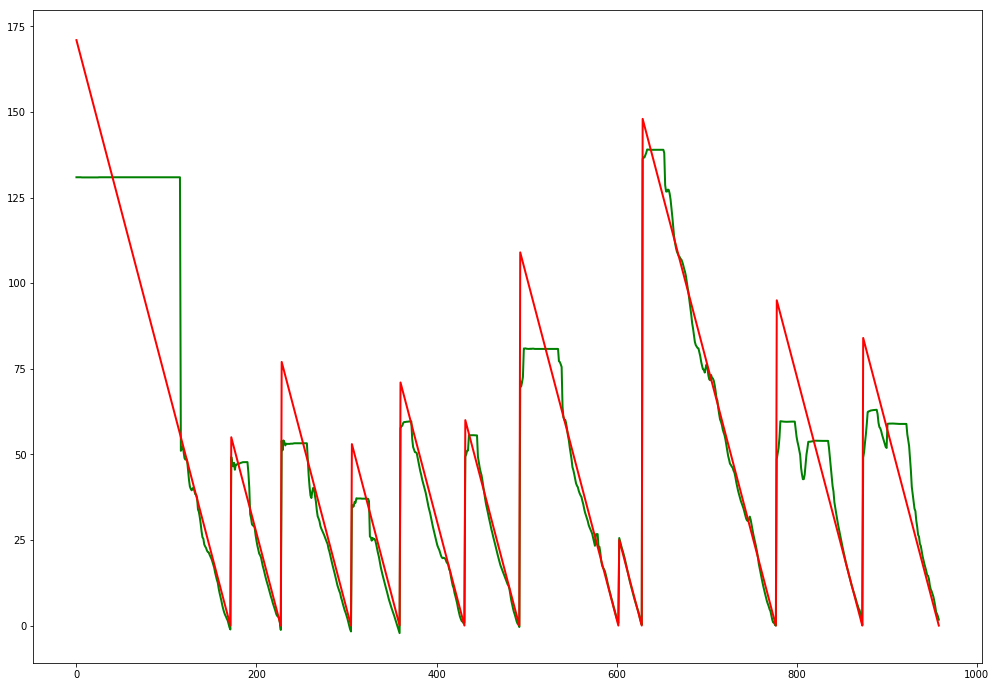

959/959 [==============================] - 0s 63us/step
[8.652714917756718, 8.652714917756718]


In [48]:
plt.rcParams['figure.figsize'] = [17, 12]
plt.plot(predictions, color='green', linewidth=2, markersize=12)
plt.plot(j_labels, color='red', linewidth=2, markersize=12)
plt.show()
print(model.evaluate(model_to_predict.values, j_labels_.values))

Note that the plot above contains all 11 segments. The first segment has trouble finding a good estimate in the beginning, probably because the bus stays idle on this station (ändhållplatsen) for a long time

## Evaluate model on all but the first segment

Create a set that ignores the first segment

In [49]:
# Drop first segment, all journeys
test_ign = test_data[test_data[1] == 0].index
test_ign_d = test_data.loc[test_ign]
test_ign_l = test_labels.loc[test_ign]

# Drop first segment, single journey

# Selected journey needs to be in the msk array
# selected_journey = np.random.choice(msk)

# Selected_journey from previous example should be used to compare loss

test_single_j = test_input[test_input['journey_number'] == selected_journey]
to_test = test_single_j.drop(columns=['journey_number'])

test_single = to_test[to_test[1] == 0].index
test_single_d = to_test.loc[test_single]
journey_ = test_labels[test_input['journey_number'] == selected_journey]
test_single_l = journey_.loc[test_single]
test_single_l = test_single_l.reset_index().drop(columns=['index'])

Evaluate model on all data

In [50]:
model.evaluate(test_ign_d.values, test_ign_l.values)

457212/457212 [==============================] - 4s 9us/step


[7.236479988598998, 7.236479988598998]

About 7 seconds m.a.e. Really good to drop the first segment!

In [51]:
predictions = model.predict(test_single_d.values, batch_size=1, verbose=1)

787/787 [==============================] - 0s 208us/step


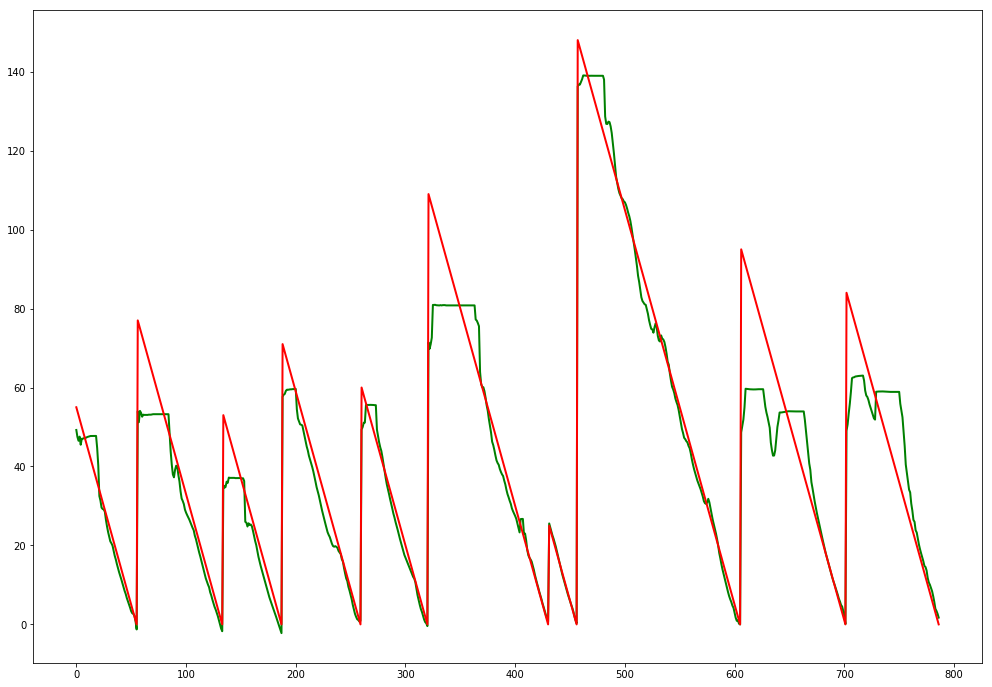

787/787 [==============================] - 0s 15us/step
[5.716812919328294, 5.716812919328294]


In [52]:
plt.rcParams['figure.figsize'] = [17, 12]
plt.plot(predictions, color='green', linewidth=2, markersize=12)
plt.plot(test_single_l, color='red', linewidth=2, markersize=12)
plt.show()
print(model.evaluate(test_single_d.values, test_single_l.values))

It is easy to see that it has troubles dealing with dwell time at bus stops.

Below is a final scatterplot from the entire test data set. But this is very hard to interpret.

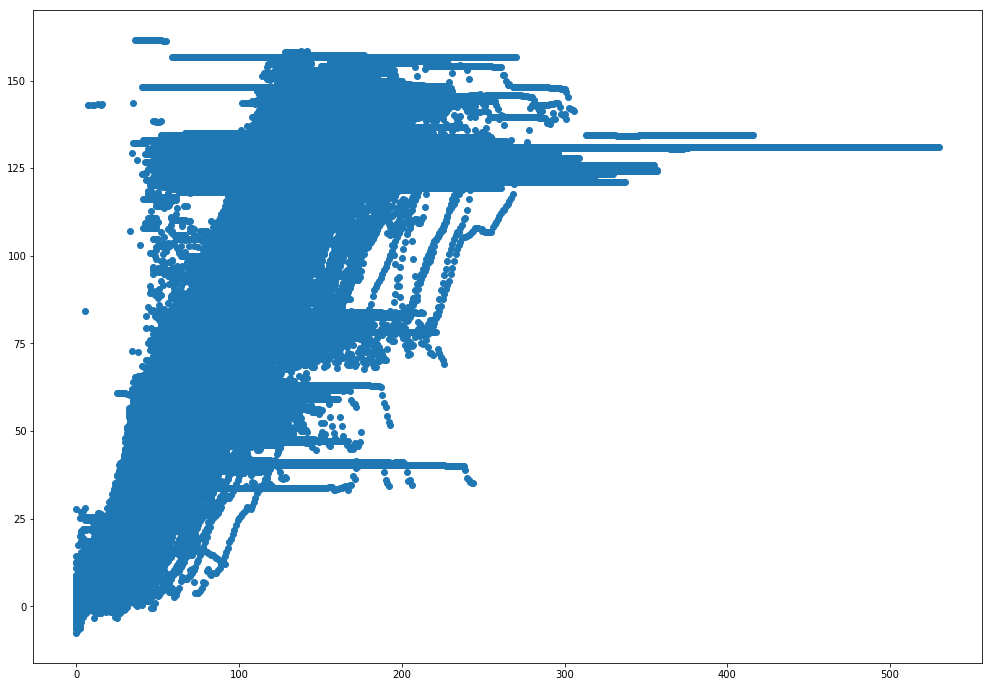

In [53]:
test_predictions = model.predict(test_data.values)
plt.scatter(test_labels.values, test_predictions)
plt.show()

## Now, lets look only at segment 9 (McD to Gamla Linköping)

In [54]:
# Drop first segment, all journeys
test_ign = test_input[test_input[9] == 1].index
test_ign_d = test_input.loc[test_ign]
test_ign_l = test_labels.loc[test_ign]
#test_ign_l = test_ign_l.reset_index().drop(columns=['index'])

In [55]:
eval_data = [] #pds.DataFrame()
eval_labels = [] #pds.DataFrame()

for i, seg in test_ign_d.groupby('journey_number'):
    n_seg = seg.drop(columns=['journey_number'])
    n_idx = n_seg.index
    pred = model.predict(n_seg, verbose=0)
    eval_data.append([pred])
    eval_labels.append([test_ign_l.loc[n_idx].reset_index().drop(columns=['index'])])
    #eval_data = pds.concat(eval_data, pred)
    #eval_labels = pds.concat(eval_labels, test_ign_l.loc[n_idx].reset_index().drop(columns=['index']), axis=2)

Looking att all predictions at the same time shows interesting results! Some journeys (the rightmost) seems to have large troubles with 

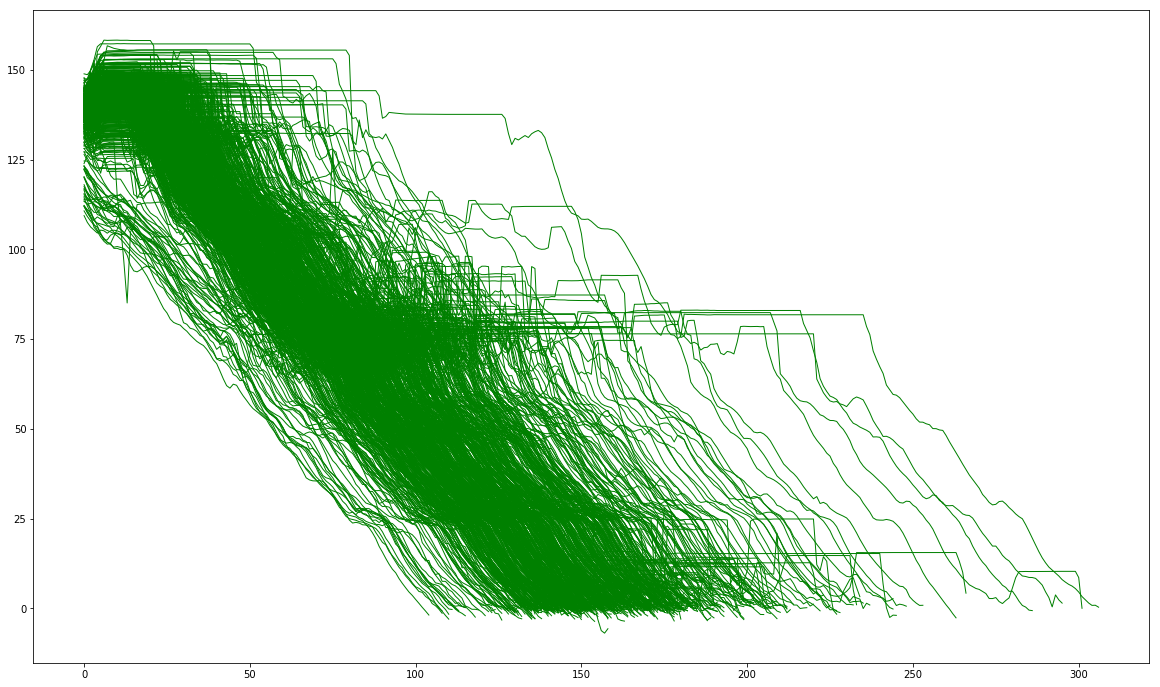

In [56]:
plt.rcParams['figure.figsize'] = [20, 12]
for i in range(len(eval_data)):
    plt.plot(eval_data[i][0], color='green', linewidth=1, markersize=2)
    #plt.plot(eval_labels[i][0], color='red', linewidth=2, markersize=12)
plt.show()
#print(model.evaluate(test_ign_d.values, test_ign_l.values))

There seems to be large variance in this segment. This is the segment containing Vallarondellen, which is known for having large traffic issues during rush hours. This is probably why some journeys are very far to the right and the actual travel time ranges from 100-350 seconds.